## Relative Strength Index(RSI)

In [82]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import backtrader as bt
import matplotlib as plt

In [83]:
class RSI(bt.Strategy):
    
    params = (('overselling_limit', 40), ('overbuying_limit', 80),)
    
    def log(self, text, dt = None):
        dt = dt or self.datas[0].datetime.date(0)
        print("%s %s" %(dt.isoformat(), text))
        
    def __init__(self):
        self.rsi = bt.indicators.RSI(self.data)
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Rejected]:
            self.log('Order Rejected')
        elif order.status in [order.Canceled]:
            self.log('Order Canceled')
        elif order.status in [order.Margin]:
            self.log('Order Margin')
        # Reset
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    def next(self):
        if self.order:
            return
        if not self.position:
            # rsi in overselling region
            if self.rsi< self.p.overselling_limit:
                self.log("Buy (Creating a long position) at %s" %self.data.close[0])
                self.order = self.buy()
            # rsi in overbuing region
            if self.rsi> self.p.overbuying_limit:
                self.log("Sell (Creating a short position) at %s" %self.data.close[0])
                self.order = self.sell()
        else:
             # if it is a long position check for selling opportunity
            if self.position.size>0 and self.rsi > self.p.overbuying_limit:
                self.log("Closing the long position at %s" %self.data.close[0])
                self.order = self.close()
            # else if it is short position check for buying opportunity
            if self.position.size<0 and self.rsi < self.p.overselling_limit:
                self.log("Closing the short postion at %s" %self.data.close[0])
                self.order = self.close()

In [84]:
#Instantiate Cerebro engine
cerebro = bt.Cerebro()

In [85]:
#Add data feed to Cerebro
data = bt.feeds.YahooFinanceCSVData(
    dataname='data/BAJFINANCE.NS.csv',
    fromdate=datetime.datetime(2018, 1,1),
    todate=datetime.datetime(2019, 12, 31))
cerebro.adddata(data)

In [86]:
#Add strategy to Cerebro
cerebro.addstrategy(RSI)


0

In [87]:
# Set our desired cash start
cerebro.broker.setcash(100000.0)
# Set the commission
cerebro.broker.setcommission(commission=0.01)

In [88]:
# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00


In [89]:
#Run Cerebro Engine
cerebro.run()

2018-02-02 Buy (Creating a long position) at 1619.54
2018-02-05 BUY EXECUTED, Price: 1590.80, Cost: 1590.80, Comm 15.91
2018-07-20 Closing the long position at 2710.36
2018-07-23 SELL EXECUTED, Price: 2709.01, Cost: 1590.80, Comm 27.09
2018-07-23 OPERATION PROFIT, GROSS 1118.21, NET 1075.21
2018-07-23 Sell (Creating a short position) at 2744.67
2018-07-24 SELL EXECUTED, Price: 2737.90, Cost: -2737.90, Comm 27.38
2018-09-10 Closing the short postion at 2605.09
2018-09-11 BUY EXECUTED, Price: 2610.41, Cost: -2737.90, Comm 26.10
2018-09-11 OPERATION PROFIT, GROSS 127.49, NET 74.01
2018-09-11 Buy (Creating a long position) at 2590.25
2018-09-12 BUY EXECUTED, Price: 2607.38, Cost: 2607.38, Comm 26.07


In [90]:
# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Final Portfolio Value: 102749.33


<IPython.core.display.Javascript object>


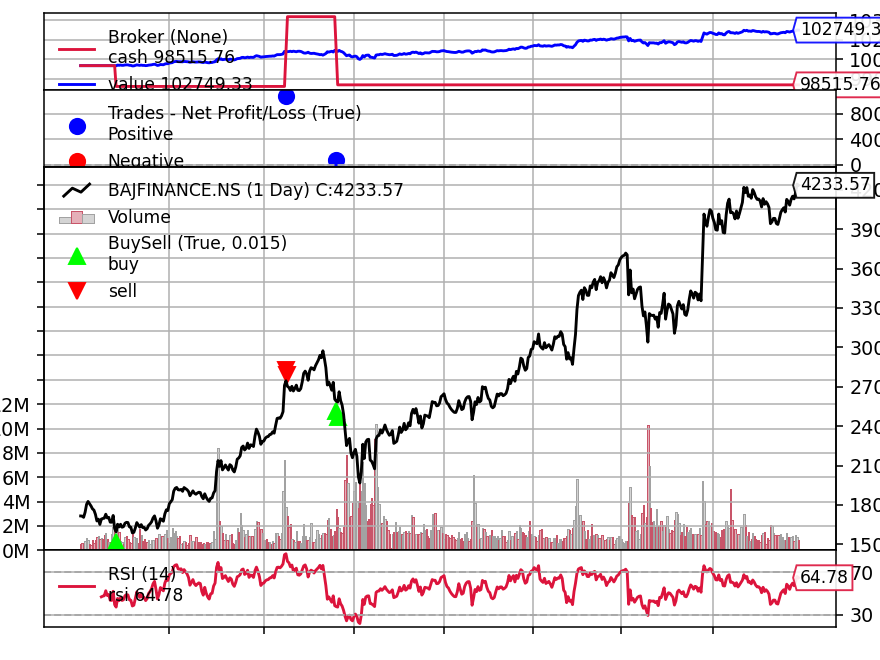

[[<Figure size 640x480 with 5 Axes>]]

In [91]:
cerebro.plot()
